In [2]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter

In [1]:
# Run this in the first cell of your Cloud Notebook
!pip install scikit-learn==1.7.2 --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 84.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.7.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.


In [8]:

a = pd.read_csv('/kaggle/input/multilingual-customer-support-tickets/aa_dataset-tickets-multi-lang-5-2-50-version.csv')
b = pd.read_csv('/kaggle/input/multilingual-customer-support-tickets/4_dataset-tickets-multi-lang4.csv')

print(a.info())
print("-------------------------------------")
print(b.info())

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/multilingual-customer-support-tickets/4_dataset-tickets-multi-lang4.csv'

In [147]:

# English only
a = a[a['language'] == 'en']
b = b[b['language'] == 'en']

# Drop nulls
a = a.dropna(subset=['priority', 'body'])
b = b.dropna(subset=['priority', 'body'])

# Keep only low, medium, high
valid_pr = ['low', 'medium', 'high']
a = a[a['priority'].isin(valid_pr)]
b = b[b['priority'].isin(valid_pr)]

# Create combined df with selected columns
s = pd.concat([a[['priority', 'body', 'subject']],
                      b[['priority', 'body', 'subject']]],
                     ignore_index=True)
s = s.sample(frac=1, random_state=42).reset_index(drop=True)


print(s.head())
print(s['priority'].value_counts())
print(s.shape)


  priority                                               body  \
0   medium  Dear Support Team,\n\nI am writing to report a...   
1     high  The company's analytics platform faced perform...   
2     high  Hi Support Team,\n\nI am submitting this repor...   
3      low  Hello Support Team,\n\nCould you please clarif...   
4   medium  Would like to know comprehensive solutions for...   

                                             subject  
0                  Accessing Corel Painter Tutorials  
1       Problems with Analytics Platform Performance  
2  Crucial System Outage Since Recently, Request ...  
3  Request for clarification on Google News Publi...  
4                                                NaN  
priority
medium    11945
high      10076
low        7768
Name: count, dtype: int64
(29789, 3)


In [5]:
df=pd.read_csv('/kaggle/input/priority/preprocessed_email.csv')

In [7]:
df['priority'].value_counts()

priority
LOW       6654
HIGH      6617
MEDIUM    5327
Name: count, dtype: int64

In [9]:
!pip list

Package                                  Version
---------------------------------------- -------------------
a2a-sdk                                  0.3.10
absl-py                                  1.4.0
accelerate                               1.9.0
aiobotocore                              2.25.1
aiofiles                                 22.1.0
aiohappyeyeballs                         2.6.1
aiohttp                                  3.13.2
aioitertools                             0.12.0
aiosignal                                1.4.0
aiosqlite                                0.21.0
alabaster                                1.0.0
albucore                                 0.0.24
albumentations                           2.0.8
ale-py                                   0.11.2
alembic                                  1.17.1
altair                                   5.5.0
annotated-types                          0.7.0
annoy                                    1.17.3
ansicolors                        

In [148]:
# Initialize tools (assuming these imports and initializations were done previously)
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Define words to remove (priority terms)
PRIORITY_TERMS = r'\b(dear|support|team|ni|hello|hope|well|customer|data|please|message|team|nan|could|would|assistance|problem|issue|failure|system|update)\b'

def clean_text(text):
    # --- FIX for AttributeError: 'float' object has no attribute 'lower' ---
    # Convert the input (which might be NaN/float) to a string before processing.
    text = str(text)

    # 1. Convert to Lowercase
    text = text.lower()
    
    # 2. Remove Escape Sequences and Newline/Tab Characters (e.g., \n, \t, \a, \b)
    text = re.sub(r'[\r\n\t\a\b]+', ' ', text)
    
    # 3. Remove Priority/Severity Terms (New Step)
    # Uses the defined regex pattern to remove terms like 'critical', 'high', etc.
    # We use re.IGNORECASE in the pattern definition (r'\b(critical|...)\b') and then convert to lower, 
    # but since we convert to lower first, we only need the lowercase terms in the list.
    text = re.sub(PRIORITY_TERMS, '', text)
    
    # 4. Remove Punctuation and Symbols
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    
    # 5. Remove leading/trailing/multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 6. Tokenization, Stop Word Removal, and Lemmatization
    tokens = text.split()
    
    # Remove Stop Words & Lemmatize (only if the resulting word is longer than 1 character)
    tokens = [
        lemmatizer.lemmatize(word) 
        for word in tokens 
        if word not in stop_words and len(word) > 1
    ]
    
    # Rejoin the tokens into a string
    return ' '.join(tokens)

In [149]:
# Assuming your DataFrame is named 'df'
s['subject'] = s['subject'].apply(clean_text)
s['body'] = s['body'].apply(clean_text)

print("\n--- After Fixed Preprocessing Sample ---")
print(s[['subject', 'body']].head())


--- After Fixed Preprocessing Sample ---
                                             subject  \
0                   accessing corel painter tutorial   
1             problem analytics platform performance   
2  crucial outage since recently request expedite...   
3  request clarification google news publisher ce...   
4                                                      

                                                body  
0  writing report accessing built tutorial corel ...  
1  company analytics platform faced performance p...  
2  hi submitting report regarding critical petspa...  
3  ncould clarify metadata guideline google news ...  
4  like know comprehensive solution securing medi...  


In [133]:
# Function to get the top N words
def get_top_words(cleaned_series, n=30):
    """Tokenizes a Series of cleaned text and returns the top N word counts."""
    all_text = ' '.join(cleaned_series)
    words = all_text.split()
    word_counts = Counter(words)
    return pd.DataFrame(word_counts.most_common(n), columns=['Word', 'Frequency'])

# Get top 30 words for Subject and Body
top_subject_words = get_top_words(s['subject'], n=30)
top_body_words = get_top_words(s['body'], n=30)

print("\n--- Top 10 Words in Subject ---")
print(top_subject_words.head(10))

print("\n--- Top 10 Words in Body ---")
print(top_body_words.head(10))


--- Top 10 Words in Subject ---
          Word  Frequency
0  integration       2120
1      request       2045
2       urgent       1794
3        delay       1693
4     security       1557
5      digital       1521
6    analytics       1418
7      medical       1358
8     required       1248
9      concern       1238

--- Top 10 Words in Body ---
          Word  Frequency
0      provide       6643
1  information       6205
2   appreciate       5970
3     software       5672
4     platform       5646
5  integration       5612
6         time       5191
7          due       5186
8        delay       5171
9       report       4960


In [154]:
priority_map = {'low': 1, 'medium': 2, 'high': 3}
reverse_priority_map = {v: k for k, v in priority_map.items()}


X = s['body']
y = s['priority']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Convert text to numerical features using TF-IDF
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

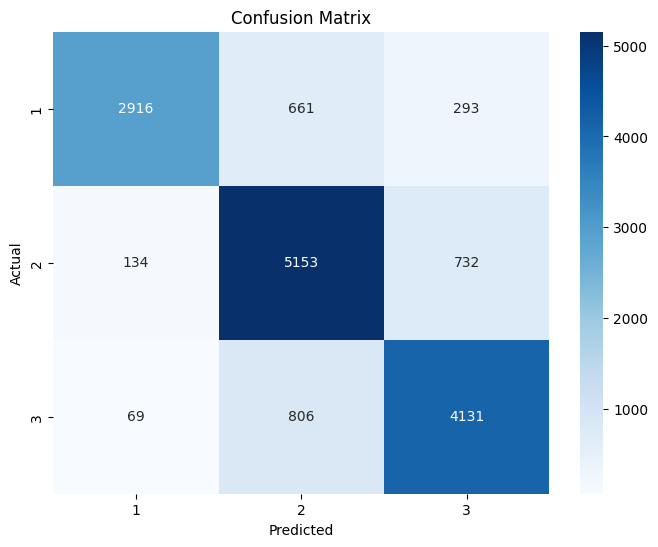

In [187]:
# Plotting Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [179]:
# Initialize and Train Random Forest
rf_model = RandomForestClassifier(n_estimators=80, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test_tfidf)
print(f"--- Random Forest Classifier Evaluation ---")
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf, zero_division=0))
print("-" * 50)

--- Random Forest Classifier Evaluation ---

✅ Accuracy: 0.8150

Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.74      0.83      3870
           2       0.78      0.86      0.82      6019
           3       0.79      0.82      0.80      5006

    accuracy                           0.82     14895
   macro avg       0.83      0.81      0.82     14895
weighted avg       0.82      0.82      0.82     14895

--------------------------------------------------


In [180]:
from sklearn.svm import SVC

# Initialize and Train SVC with Polynomial Kernel
# We specify degree=2 (quadratic boundary)
poly_svc_model = SVC(kernel='poly', degree=2, random_state=42)
# Note: This may also take a long time to train.
poly_svc_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_poly = poly_svc_model.predict(X_test_tfidf)
print(f"--- Polynomial Kernel SVC (Degree 2) Evaluation ---")
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred_poly):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_poly, zero_division=0))
print("-" * 50)

--- Polynomial Kernel SVC (Degree 2) Evaluation ---

✅ Accuracy: 0.8191

Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.75      0.83      3870
           2       0.78      0.86      0.82      6019
           3       0.80      0.83      0.81      5006

    accuracy                           0.82     14895
   macro avg       0.84      0.81      0.82     14895
weighted avg       0.83      0.82      0.82     14895

--------------------------------------------------


In [162]:
# Initialize and Train LinearSVC
svc_model = LinearSVC(random_state=42, dual=False, max_iter=1000)
svc_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_svc = svc_model.predict(X_test_tfidf)
print(f"--- Linear Support Vector Machine (LinearSVC) Evaluation ---")
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred_svc):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svc, zero_division=0))
print("-" * 50)

In [163]:
from sklearn.svm import SVC

# Initialize and Train SVC with RBF Kernel
# RBF kernel is the default, but we specify it for clarity.
rbf_svc_model = SVC(kernel='rbf', random_state=42) 
# Note: This may take significantly longer to train than LinearSVC.
rbf_svc_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_rbf = rbf_svc_model.predict(X_test_tfidf)
print(f"--- RBF Kernel SVC Evaluation ---")
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred_rbf):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rbf, zero_division=0))
print("-" * 50)

--- RBF Kernel SVC Evaluation ---

✅ Accuracy: 0.7902

Classification Report:
              precision    recall  f1-score   support

           1       0.94      0.69      0.80      3870
           2       0.74      0.85      0.79      6019
           3       0.78      0.80      0.79      5006

    accuracy                           0.79     14895
   macro avg       0.82      0.78      0.79     14895
weighted avg       0.80      0.79      0.79     14895

--------------------------------------------------


In [157]:
# Initialize and Train Multinomial Naive Bayes
mnb_model = MultinomialNB()
mnb_model.fit(X_train_tfidf, y_train)

# Evaluate
y_pred_mnb = mnb_model.predict(X_test_tfidf)
print(f"--- Multinomial Naive Bayes (MNB) Evaluation ---")
print(f"\n✅ Accuracy: {accuracy_score(y_test, y_pred_mnb):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_mnb, zero_division=0))
print("-" * 50)

--- Multinomial Naive Bayes (MNB) Evaluation ---

✅ Accuracy: 0.6757

Classification Report:
              precision    recall  f1-score   support

           1       0.88      0.54      0.67      3870
           2       0.65      0.73      0.69      6019
           3       0.63      0.71      0.67      5006

    accuracy                           0.68     14895
   macro avg       0.72      0.66      0.67     14895
weighted avg       0.70      0.68      0.67     14895

--------------------------------------------------


In [194]:
# --- Collect all trained models ---
trained_models = {
    "Random Forest Classifier": rf_model,
    "LinearSVC": svc_model,
    "Multinomial Naive Bayes (MNB)": mnb_model,
    "RBF SVC Model":rbf_svc_model,
    "Poly SVC Model":poly_svc_model
}

# --- Sample Tickets ---
new_tickets = ["failure in my software", "The website is down", "How do I reset my password?"]
new_tickets_tfidf = tfidf.transform(new_tickets)

print("--- Sample Tickets for Prediction ---")
for i, ticket in enumerate(new_tickets):
    print(f"Ticket {i+1}: '{ticket}'")

print("\n--- Model Predictions ---")
print("-" * 35)

for name, model in trained_models.items():
    # Make the numeric predictions
    numeric_predictions = model.predict(new_tickets_tfidf)
    
    # Map the numbers back to the original labels
    predicted_labels = [reverse_priority_map.get(p, "Error") for p in numeric_predictions]
    
    # Print the results
    print(f"\n**{name}**")
    for i, label in enumerate(predicted_labels):
        print(f"  Ticket {i+1} Priority: **{label}**")
    print("-" * 35)

--- Sample Tickets for Prediction ---
Ticket 1: 'failure in my software'
Ticket 2: 'The website is down'
Ticket 3: 'How do I reset my password?'

--- Model Predictions ---
-----------------------------------

**Random Forest Classifier**
  Ticket 1 Priority: **high**
  Ticket 2 Priority: **medium**
  Ticket 3 Priority: **high**
-----------------------------------

**LinearSVC**
  Ticket 1 Priority: **high**
  Ticket 2 Priority: **medium**
  Ticket 3 Priority: **medium**
-----------------------------------

**Multinomial Naive Bayes (MNB)**
  Ticket 1 Priority: **high**
  Ticket 2 Priority: **medium**
  Ticket 3 Priority: **high**
-----------------------------------

**RBF SVC Model**
  Ticket 1 Priority: **high**
  Ticket 2 Priority: **medium**
  Ticket 3 Priority: **high**
-----------------------------------

**Poly SVC Model**
  Ticket 1 Priority: **high**
  Ticket 2 Priority: **medium**
  Ticket 3 Priority: **high**
-----------------------------------


In [193]:
# Example: Predicting the priority of new tickets
model=poly_svc_model
new_tickets = ["critical failure in my software", "The website is down", "How do I reset my password?"]
new_tickets_tfidf = tfidf.transform(new_tickets)
predicted_priorities = model.predict(new_tickets_tfidf)
predicted_labels = [reverse_priority_map.get(p, "Error") for p in predicted_priorities]
print("Predicted priorities:", predicted_labels)

Predicted priorities: ['high', 'medium', 'high']


In [183]:
import joblib
import os
# The trained_models dictionary is assumed to contain the fitted models

# 1. Define the directory where models will be saved
MODEL_DIR = 'trained_priority_models'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    print(f"Created directory: {MODEL_DIR}")

print("\n--- Saving All Trained Models ---")
# 2. Iterate and save each model
for name, model in trained_models.items():
    # Sanitize the name for use as a filename
    filename = name.lower().replace(" ", "_") + '.joblib'
    file_path = os.path.join(MODEL_DIR, filename)
    
    # Save the model
    joblib.dump(model, file_path)
    print(f"✅ Saved {name} to: {file_path}")

print("-" * 50)
print("All models and the TF-IDF vectorizer should be saved to deploy the pipeline.")


--- Saving All Trained Models ---
✅ Saved Random Forest Classifier to: trained_priority_models/random_forest_classifier.joblib
✅ Saved LinearSVC to: trained_priority_models/linearsvc.joblib
✅ Saved Multinomial Naive Bayes (MNB) to: trained_priority_models/multinomial_naive_bayes_(mnb).joblib
✅ Saved RBF SVC Model to: trained_priority_models/rbf_svc_model.joblib
✅ Saved Poly SVC Model to: trained_priority_models/poly_svc_model.joblib
--------------------------------------------------
All models and the TF-IDF vectorizer should be saved to deploy the pipeline.


In [184]:
# Saving the TF-IDF Vectorizer ---
tfidf_filename = os.path.join(MODEL_DIR, 'tfidf_vectorizer.joblib')
joblib.dump(tfidf, tfidf_filename)
print(f"✅ Saved TF-IDF Vectorizer to: {tfidf_filename}")

✅ Saved TF-IDF Vectorizer to: trained_priority_models/tfidf_vectorizer.joblib


In [206]:
# Example of how to load a model later
loaded_rf_model = joblib.load('trained_priority_models/random_forest_classifier.joblib')
loaded_tfidf = joblib.load('trained_priority_models/tfidf_vectorizer.joblib')
p=["my software is not working"]
tf=loaded_tfidf.transform(p)
prd=loaded_rf_model.predict(tf)
prdt = [reverse_priority_map.get(p, "Error") for p in prd]
print(prdt)

['medium']
